In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


# Grouping by flight and distinguishing adult/juvenile passengers

In [3]:
# There is probably a better way to do this step to include a FiscalYear and exact date.
# Could add a FiscalYear column in `../../clean/`?

df['FiscalYear'] = df['MissionDate'].copy()
df.set_index('MissionDate', drop=False, inplace=True)
df.index.name = 'FiscalYear'

# Grouping records by exact date, fiscal year, MissionID,
# removal or transfer status, unique pickup/dropoff, juvenile status.
# Can't group by nationality here or it splits flights up and obscures trends
# Grouping by pickup/dropoff also possibly splits up flights
# g = df.groupby([pd.Grouper(freq='AS-OCT'), 'MissionDate', 'MissionID', 'R-T', 'PULOC', 'DropLoc', 'Juvenile'])
g = df.groupby([pd.Grouper(freq='AS-OCT'), 'MissionDate', 'MissionID', 'R-T', 'Juvenile'])

t = g.agg({'AlienMasterID': pd.Series.nunique}) # Counting unique AlienMasterID values per flight

t = t.unstack('Juvenile') # Splitting our count of unique AlienMasterIDs into categories by juvenile status
t = t['AlienMasterID'].reset_index() # There's probably a better way of doing this than `reset_axis()`

t.columns.name = None
t = t.rename({False: 'AdultCount', True: 'JuvCount'}, axis=1)

t[['AdultCount', 'JuvCount']] = t[['AdultCount', 'JuvCount']].fillna(0)
t['TotalCount'] = t['AdultCount'] + t['JuvCount']
t['JuvPercent'] = t['JuvCount'] / t['TotalCount']

t.set_index('MissionDate', inplace=True)
t.head()

,FiscalYear,MissionID,R-T,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,
2010-10-01,2010-10-01,105,T,121.0,1.0,122.0,0.008197
2010-10-01,2010-10-01,106,R,104.0,0.0,104.0,0.000000
2010-10-01,2010-10-01,107,R,97.0,0.0,97.0,0.000000
2010-10-01,2010-10-01,108,R,98.0,0.0,98.0,0.000000
2010-10-01,2010-10-01,108,T,35.0,0.0,35.0,0.000000


Now we make separate DataFrames for removal and transfer flights.

In [4]:
tr = t[t['R-T'] == 'R'].copy()
tr.sort_index(inplace=True)
tt = t[t['R-T'] == 'T'].copy()
tt.sort_index(inplace=True)

We can discern an increase in the percentage of juveniles on removal flights from 2015 on.

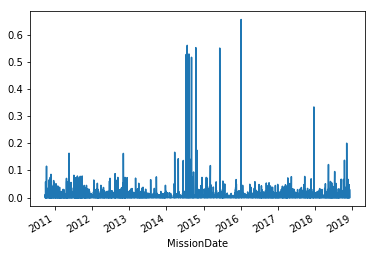

In [10]:
tr['JuvPercent'].plot();

The number of juveniles on a given flight, however, is low, with a few exceptions.

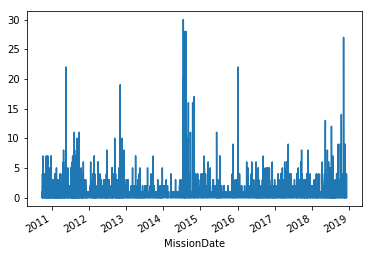

In [9]:
tr['JuvCount'].plot();

A cumulative plot of juvenile removals shows an abrupt bump in mid-2014, and an increasing trend since 2018.

In [12]:
def cumulative_chart(data, title=str, filename=str, ylabel=str, xlabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot()

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

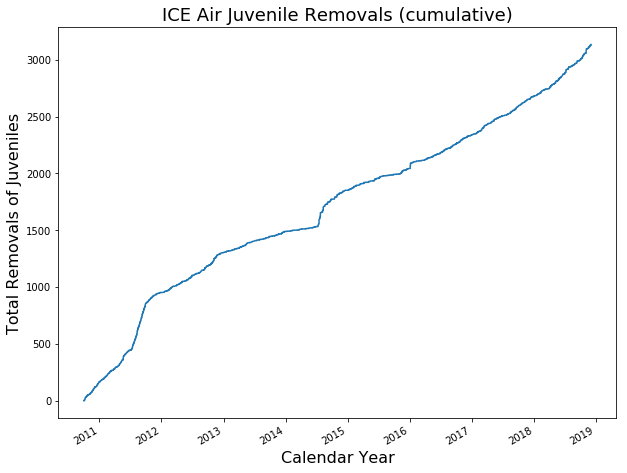

In [13]:
cumulative_chart(tr['JuvCount'].cumsum(),
                title="ICE Air Juvenile Removals (cumulative)",
                ylabel="Total Removals of Juveniles",
                xlabel='Calendar Year',
                filename='cumulative_juvenile_removals');

Given the frequency of transfer flights, especially during 2012-2015, it's harder to discern trends in percentages of transfers of juveniles, but we note many fewer since 2015.

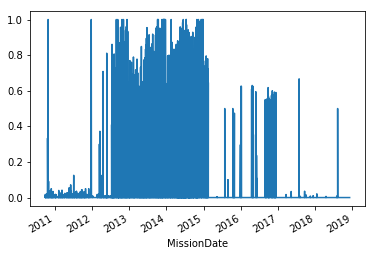

In [9]:
tt['JuvPercent'].plot()

Looking at a smaller segment of the above plot with individual flights marked as points shows that this plot obscures overall trends, because there are often multiple flights on a given day.

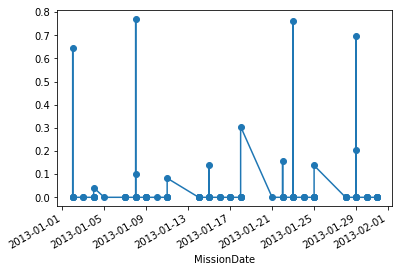

In [10]:
tt['2013-01']['JuvPercent'].plot(style='o-')

Plot of absolute number of juveniles on transfer flights is much clearer, showing a huge surge of transfers of juveniles from mid-2013 through 2014. What might be driving that?

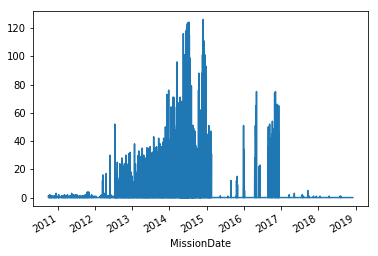

In [11]:
tt['JuvCount'].plot()

Cumulative plot of juvenile transfers is striking, but very strange. Huge rate of juveniles transfered during 2013-2015, almost none since?

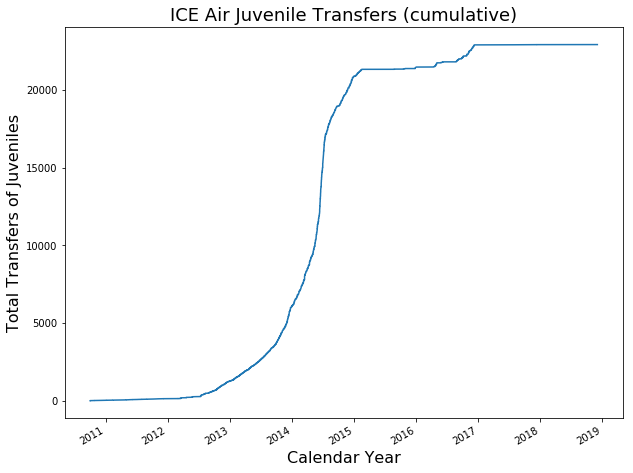

In [14]:
cumulative_chart(tt['JuvCount'].cumsum(),
                title="ICE Air Juvenile Transfers (cumulative)",
                ylabel="Total Transfers of Juveniles",
                xlabel='Calendar Year',
                filename='cumulative_juvenile_transfers');

# Juveniles by specific nationality

First we group records by CountryOfCitizenship, Fiscal Year and MissionDate, MissionID, Removal or Transfer status, Pickup/Dropoff Location, and juvenile status.

In [24]:
# g_nat = df.groupby(['CountryOfCitizenship', pd.Grouper(freq='AS-OCT'), 'MissionDate', 'MissionID', 'R-T', 'PULOC', 'DropLoc', 'Juvenile'])
g_nat = df.groupby(['CountryOfCitizenship', pd.Grouper(freq='AS-OCT'), 'MissionDate', 'MissionID', 'R-T', 'Juvenile'])
t_nat = g_nat.agg({'AlienMasterID': pd.Series.nunique}) # Counting unique AlienMasterID values per flight

t_nat = t_nat.unstack('Juvenile') # Splitting our count of unique AlienMasterIDs into categories by juvenile status
t_nat = t_nat['AlienMasterID'].reset_index() # There's probably a better way of doing this than `reset_axis()`

t_nat.columns.name = None
t_nat = t_nat.rename({False: 'AdultCount', True: 'JuvCount'}, axis=1)

t_nat[['AdultCount', 'JuvCount']] = t_nat[['AdultCount', 'JuvCount']].fillna(0)
t_nat['TotalCount'] = t_nat['AdultCount'] + t_nat['JuvCount']
t_nat['JuvPercent'] = t_nat['JuvCount'] / t_nat['TotalCount']

t_nat.set_index('MissionDate', inplace=True)
t_nat.head()

,CountryOfCitizenship,FiscalYear,MissionID,R-T,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,
2010-10-14,ALGERIA,2010-10-01,182,T,1.0,0.0,1.0,0.0
2010-10-15,ALGERIA,2010-10-01,187,T,1.0,0.0,1.0,0.0
2011-01-31,ALGERIA,2010-10-01,769,T,1.0,0.0,1.0,0.0
2012-12-18,ALGERIA,2012-10-01,5297,T,1.0,0.0,1.0,0.0
2014-07-14,ALGERIA,2013-10-01,9022,T,1.0,0.0,1.0,0.0


In [25]:
tr_nat = t_nat[t_nat['R-T'] == 'R'].copy()
tr_nat.sort_index(inplace=True)
tt_nat = t_nat[t_nat['R-T'] == 'T'].copy()
tt_nat.sort_index(inplace=True)

Subsequent cells will retrieve data, primarily focusing on removals, for the target nationality. Remember only a small number of nationalities have a significant number of removals of juveniles.

In [26]:
nationality = 'GUATEMALA'

In [27]:
if nationality.upper() in df['CountryOfCitizenship'].str.upper().unique():
    pass
else:
    print(f'{nationality} not represented in dataset')

In [28]:
nat_removals = tr_nat[tr_nat['CountryOfCitizenship'] == nationality.upper()].copy()
nat_transfers = tt_nat[tt_nat['CountryOfCitizenship'] == nationality.upper()].copy()

In [29]:
nat_removals.head()

,CountryOfCitizenship,FiscalYear,MissionID,R-T,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,
2010-10-01,GUATEMALA,2010-10-01,106,R,104.0,0.0,104.0,0.000000
2010-10-01,GUATEMALA,2010-10-01,132,R,121.0,0.0,121.0,0.000000
2010-10-04,GUATEMALA,2010-10-01,112,R,42.0,4.0,46.0,0.086957
2010-10-05,GUATEMALA,2010-10-01,115,R,135.0,0.0,135.0,0.000000
2010-10-06,GUATEMALA,2010-10-01,148,R,43.0,0.0,43.0,0.000000


In [30]:
nat_annual = nat_removals.groupby(['FiscalYear', 'CountryOfCitizenship'])[['JuvCount', 'TotalCount']].sum().dropna()

In [31]:
nat_annual['JuvPercent'] = nat_annual['JuvCount'] / nat_annual['TotalCount'] *100

In [32]:
nat_annual = nat_annual.reset_index()
nat_annual.set_index('FiscalYear', inplace=True)

In [33]:
nat_annual.to_csv(f'../output/{nationality}_annual_juv_versus_total.csv')

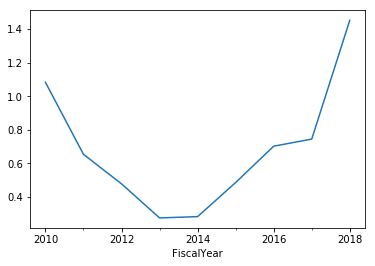

In [34]:
nat_annual['JuvPercent'].plot()

In [270]:
guate_juv_removals = nat_removals['JuvCount'].cumsum()

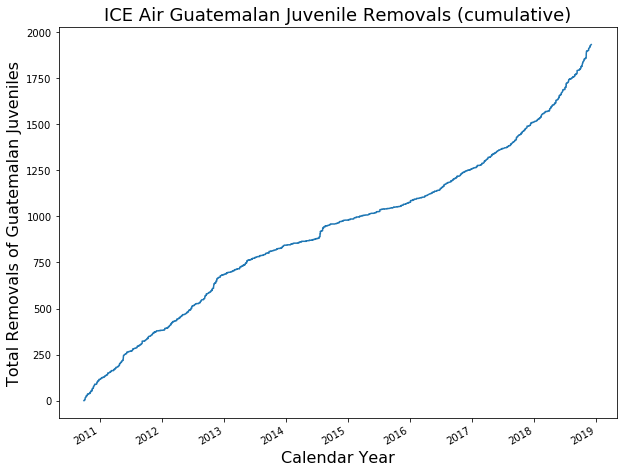

In [271]:
cumulative_chart(guate_juv_removals,
                title="ICE Air Guatemalan Juvenile Removals (cumulative)",
                ylabel="Total Removals of Guatemalan Juveniles",
                xlabel='Calendar Year',
                filename='guatemala_cumulative_juvenile_removals');

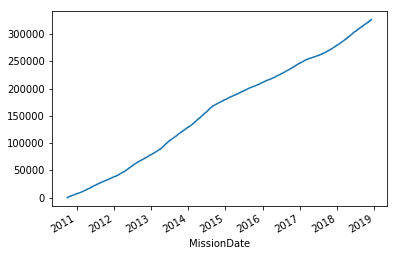

In [36]:
r_cum = nat_removals['TotalCount'].cumsum()
t_cum = nat_removals['TotalCount'].cumsum()

r_cum.plot();

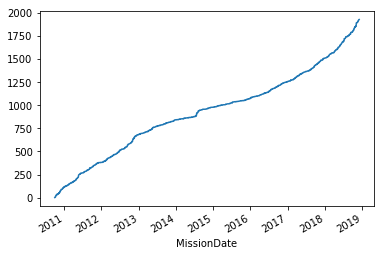

In [37]:
juv_r_cum = nat_removals['JuvCount'].cumsum()

juv_r_cum.plot()

In [38]:
nat_removals['JuvCount'].max()

27.0

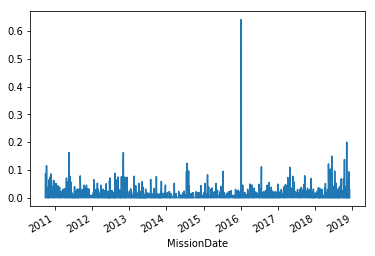

In [39]:
nat_removals['JuvPercent'].plot();

In [40]:
nat_removals[nat_removals['JuvPercent'] == 1]

,CountryOfCitizenship,FiscalYear,MissionID,R-T,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,,


In [41]:
only_nat_juveniles = list(nat_removals[nat_removals['JuvPercent'] == 1]['MissionID'])

In [42]:
only_nat_juveniles

[]

In [43]:
t[t['MissionID'].isin(only_nat_juveniles)].sort_values(by='MissionID')

,FiscalYear,MissionID,R-T,AdultCount,JuvCount,TotalCount,JuvPercent
MissionDate,,,,,,,


# Annual trends in juvenile removals by country

Annual counts of removals of juveniles from all countries. Could make version that includes total removals.

In [273]:
annual = tr_nat.groupby(['FiscalYear', 'CountryOfCitizenship'])['JuvCount'].sum()

In [274]:
annual = annual.reset_index()
annual.set_index('FiscalYear', inplace=True)

In [275]:
# annual = annual['2010':'2017']

In [276]:
all_nationalities_annual = pd.pivot_table(data=annual,
                       index=annual.index,
                       columns='CountryOfCitizenship',
                       values='JuvCount',
                       aggfunc=np.sum,
                       fill_value=0)

In [277]:
# Dropping columns where all values are 0.
all_nationalities_juvcount_annual = all_nationalities_annual.loc[:, (all_nationalities_annual != 0).any(axis=0)]

In [278]:
all_nationalities_juvcount_annual

CountryOfCitizenship,COLOMBIA,ECUADOR,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,JAMAICA,MEXICO,NICARAGUA,UNKNOWN,VIETNAM,UNITED STATES OF AMERICA
FiscalYear,,,,,,,,,,,,
2010-10-01,1,7,44,330,0,44,1,429,6,0,0,0
2011-10-01,1,0,8,251,3,17,0,49,1,1,1,0
2012-10-01,0,0,4,229,0,7,0,19,0,0,0,0
2013-10-01,0,3,41,149,0,124,0,11,0,0,0,0
2014-10-01,0,0,71,92,0,29,0,27,0,0,0,0
2015-10-01,0,0,77,160,0,13,0,19,0,0,0,0
2016-10-01,0,0,89,226,14,0,0,0,0,0,0,0
2017-10-01,0,0,36,363,0,1,0,5,0,2,0,0
2018-10-01,0,0,2,133,0,0,0,0,0,1,0,1


In [279]:
all_nationalities_juvcount_annual.to_csv('../output/all_nationalities_juvcount_annual.csv')

Only a few countries make up vast majority of removals of juveniles. Here we select top 4 countries overall, sum all others into separate category for nicer-looking charts.

In [280]:
top4 = list(annual.groupby(['CountryOfCitizenship'])['JuvCount'].sum().sort_values(ascending=False).head(4).index)

In [281]:
top_4_df = pd.DataFrame()
top_4_df = top_4_df.append(annual[annual['CountryOfCitizenship'].isin(top4)])
top_4_df.index = top_4_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top4)]
    all_other_count = temp2['JuvCount'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'JuvCount'],
                            index=[year])
    top_4_df = top_4_df.append(other_df)

In [282]:
top_4_df.sort_index(inplace=True)
top_4_df.index = [f'FY{str(x)[2:4]}' for x in top_4_df.index + 1]

In [283]:
top_4_df['CountryOfCitizenship'] = top_4_df['CountryOfCitizenship'].astype('category')

In [284]:
top_4_data = pd.pivot_table(data=top_4_df,
                       index=top_4_df.index,
                       columns='CountryOfCitizenship',
                       values='JuvCount',
                       aggfunc=np.sum,
                       fill_value=0)

In [285]:
top_4_data

CountryOfCitizenship,ALL OTHERS,EL SALVADOR,GUATEMALA,HONDURAS,MEXICO
FY11,15,44,330,44,429
FY12,7,8,251,17,49
FY13,0,4,229,7,19
FY14,3,41,149,124,11
FY15,0,71,92,29,27
FY16,0,77,160,13,19
FY17,14,89,226,0,0
FY18,2,36,363,1,5
FY19,2,2,133,0,0


In [286]:
top_4_data = top_4_data.reindex(top_4_data.sum().sort_values(ascending=False).index, axis=1)

Massive decrease in removals of Mexican juveniles between FY11-12, possibly as result of implementation of DACA?

In [287]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

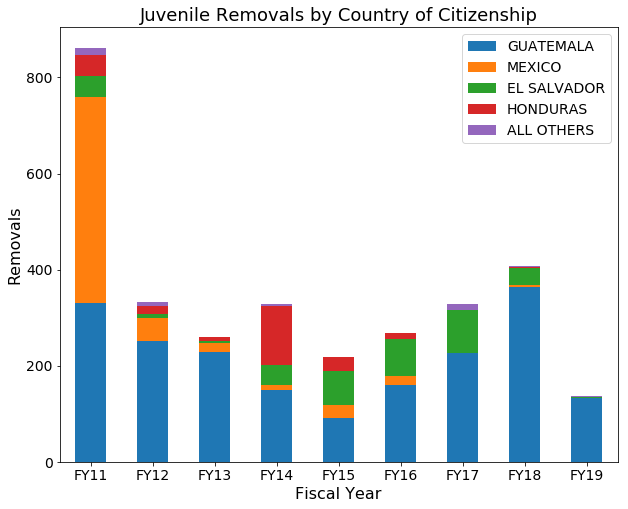

In [288]:
country_of_citizenship_trend(top_4_data,
                             title="Juvenile Removals by Country of Citizenship",
                             filename='juvenile_removals_trend',
                             xlabel="Fiscal Year",
                             ylabel="Removals");

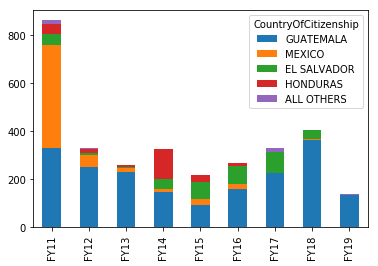

In [289]:
top_4_data.plot(kind='bar', stacked=True)

Different ways of plotting cumulative removals, but a bit hard to interpret trends.

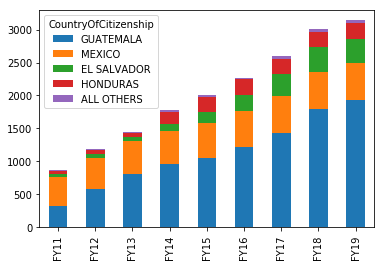

In [290]:
top_4_data.cumsum().plot(kind='bar', stacked=True)

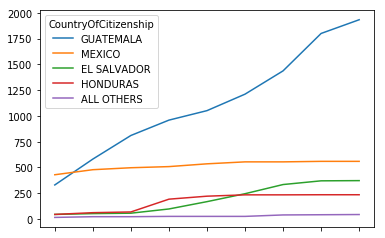

In [291]:
top_4_data.cumsum().plot(kind='line', stacked=False)

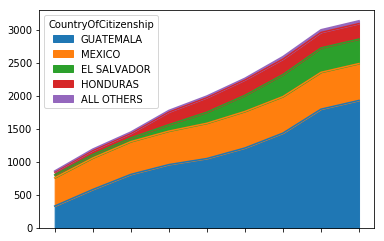

In [292]:
top_4_data.cumsum().plot(kind='area', stacked=True)

In [293]:
top_4_data.columns = top_4_data.columns.astype('str')

In [294]:
top_4_data.columns = top_4_data.columns.str.title()

In [295]:
totals = top_4_data.sum()

In [296]:
totals.name = ''

In [297]:
def pie_chart(data, title=str, filename=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='pie',
            autopct='%1.0f%%',
            pctdistance=0.85,
            labeldistance=1.1,
            fontsize=14)

#     ax.set_ylabel(ylabel, fontsize=16)
#     ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)

    fig.set_size_inches(8, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

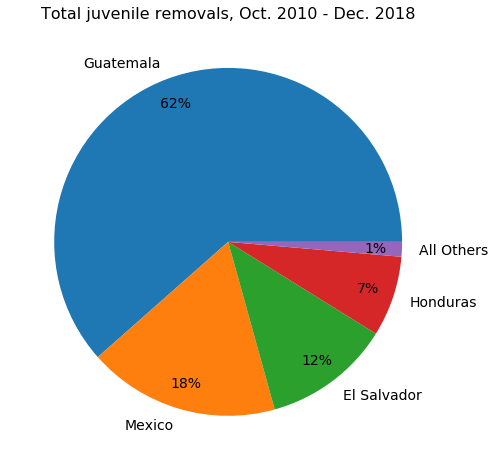

In [299]:
pie_chart(totals, title='Total juvenile removals, Oct. 2010 - Dec. 2018', filename='juvenile_piechart');